# Adaptive distances

It uses a distance between simulations $s$ and observed data $s_\text{obs}$ (or summary statistics representations thereof)

$$d(s, s_\text{obs}) = \left [\sum_{j} \left| w_j ( s_j-s_{\text{obs},j} ) \right|^{p} \right ]^{1/p}$$

with weights $w$ and exponent $p\geq 1$. E.g., $p=2$ gives a weighted Euclidean distance, $p=1$ a Manhattan distance, $p=\inf$ a maximum distance.

## Scale normalization

The concept is based on this seminal work by [Dennis Prangle 2017](https://doi.org/10.1214/16-BA1002):

    Dennis Prangle.
    Adapting the ABC distance function.
    Bayesian Analysis 12.1 (2017): 289-309.

For illustration, we consider a simple Gaussian model:

In [ ]:
# install if not done yet
!pip install pyabc --quiet

In [ ]:
import logging
import tempfile

import matplotlib.pyplot as pyplot
import numpy as np

import pyabc

In [1]:
pyabc.settings.set_figure_params("pyabc")  # for beautified plots


# for debugging
df_logger = logging.getLogger("ABC.Distance")
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {
        "s1": p["theta"] + 1 + 0.1 * np.random.normal(),
        "s2": 2 + 10 * np.random.normal(),
    }


# true model parameter
theta_true = 3

# observed summary statistics
observation = {"s1": theta_true + 1, "s2": 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV("uniform", 0, 10))

# database
db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")


def plot_history(history):
    """Plot 1d posteriors over time."""
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=0,
            xmax=10,
            x="theta",
            ax=ax,
            label=f"PDF t={t}",
            refval={"theta": theta_true},
            refval_color="grey",
        )
    ax.legend()

Summary statistic s2 has a high variance compared to summary statistic s1. In addition, s1 is informative about the model parameters $\theta$, s2 is not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled s1 decreases iteratively, while the variability of the sampled s2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of s2, so that convergence can be slowed down. In contrast, if we weight s1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance with uniform weights (i.e. $w\equiv 1$):

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2021-07-31 00:17:50>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 7.22523380e+00.
ABC INFO: Accepted: 100 / 220 = 4.5455e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 4.66705713e+00.
ABC INFO: Accepted: 100 / 346 = 2.8902e-01, ESS: 9.5308e+01.
ABC INFO: t: 2, eps: 3.48952553e+00.
ABC INFO: Accepted: 100 / 455 = 2.1978e-01, ESS: 9.6360e+01.
ABC INFO: t: 3, eps: 2.33329093e+00.
ABC INFO: Accepted: 100 / 694 = 1.4409e-01, ESS: 9.7454e+01.
ABC INFO: t: 4, eps: 1.75450228e+00.
ABC INFO: Accepted: 100 / 971 = 1.0299e-01, ESS: 9.6018e+01.
ABC INFO: t: 5, eps: 1.24596161e+00.
ABC INFO: Accepted: 100 / 1347 = 7.4239e-02, ESS: 9.6775e+01.
ABC INFO: t: 6, eps: 9.14401554e-01.
ABC INFO: Accepted: 100 / 1823 = 5.4855e-02, ESS: 9.4755e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:06.779002, end_time=2021-07-31 00:17:57>


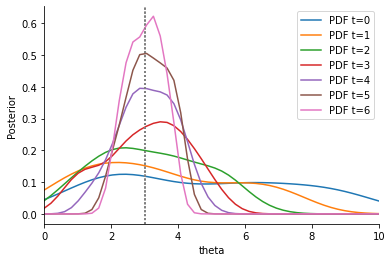

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)

abc.new(db_path, observation)

h_uni = abc.run(max_nr_populations=7)

plot_history(h_uni)

Second, we consider an adaptive Euclidean distance:

ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=2, start_time=2021-07-31 00:17:58>
ABC INFO: Calibration sample t = -1.
ABC.Distance DEBUG: Scale weights[0] = {'s1': 4.0506e-01, 's2': 1.5023e-01}
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.85312043e+00.
ABC INFO: Accepted: 100 / 186 = 5.3763e-01, ESS: 1.0000e+02.
ABC.Distance DEBUG: Scale weights[1] = {'s1': 4.1169e-01, 's2': 1.4321e-01}
ABC INFO: t: 1, eps: 1.09137591e+00.
ABC INFO: Accepted: 100 / 244 = 4.0984e-01, ESS: 9.6941e+01.
ABC.Distance DEBUG: Scale weights[2] = {'s1': 7.7012e-01, 's2': 1.7499e-01}
ABC INFO: t: 2, eps: 1.15608334e+00.
ABC INFO: Accepted: 100 / 408 = 2.4510e-01, ESS: 9.8461e+01.
ABC.Distance DEBUG: Scale weights[3] = {'s1': 9.2552e-01, 's2': 1.4981e-01}
ABC INFO: t: 3, eps: 8.19463892e-01.
ABC INFO: Accepted: 100 / 518 = 1.9305e-01, ESS: 9.9834e+01.
ABC.Distance DEBUG: Scale

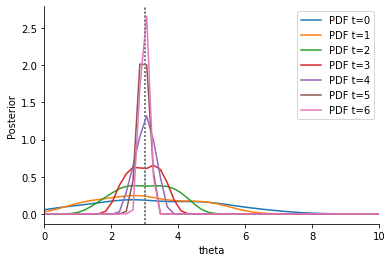

In [3]:
scale_log_file = tempfile.mkstemp(suffix=".json")[1]

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=2,
    scale_function=pyabc.distance.mad,  # method by which to scale
    scale_log_file=scale_log_file,
)

abc = pyabc.ABCSMC(model, prior, distance_adaptive)

abc.new(db_path, observation)

h_ada = abc.run(max_nr_populations=7)

plot_history(h_ada)

In the debug output of `abc.run` above, it can be seen how the weights evolve over time. In the posterior plot, we observe how, compared to the non-adaptive distance, the densitities tend to be narrower around the true parameter $\theta=3$. In addition, despite the better convergence, the required number of samples in total is lower, as can be seen from the below sample numbers plot, as not so much time was wasted trying to match an uninformative summary statistic.

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

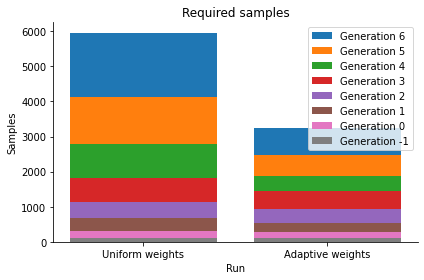

In [4]:
histories = [h_uni, h_ada]
labels = ["Uniform weights", "Adaptive weights"]
pyabc.visualization.plot_sample_numbers(histories, labels)

Indeed, the acceptance rates for the adaptive distance function are consistently higher:

<AxesSubplot:title={'center':'Acceptance rates'}, xlabel='Population index $t$', ylabel='Acceptance rate'>

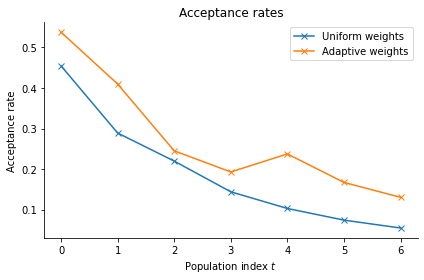

In [5]:
pyabc.visualization.plot_acceptance_rates_trajectory(histories, labels)

The log file stores the weights of each generation, allowing for further analysis. We can see that indeed ss1 is assigned a higher weight than ss2, the ratio increasing over time.

<AxesSubplot:xlabel='Summary statistic', ylabel='Weight'>

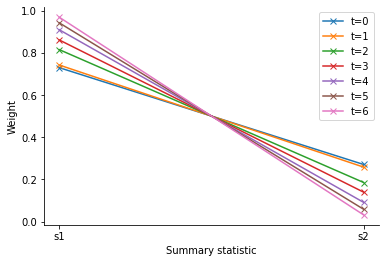

In [6]:
ts = list(range(h_ada.max_t + 1))
labels = [f"t={t}" for t in ts]

pyabc.visualization.plot_distance_weights(
    log_files=scale_log_file,
    ts=ts,
    labels=labels,
)

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a calibration sample from the prior), the method `update()` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via `configure_sampler()`, the distance function tells the sampler to not only record accepted particles, but all that were generated during the sampling process.

Above, the acceptance step uses in each generation only the distance based on the current weights. Sometimes it may be preferable to have nested acceptance regions, by also checking all previous acceptance criteria. This can be realized by passing a `acceptor=pyabc.UniformAcceptor(use_complete_history=True)` to the `ABCSMC` class.

For scale normalization, we used as a measure of sample variability above the median absolute deviation (MAD), a robust alternative to the standard deviation. Other measures are possible and implemented in `pyabc.distance.scale`.

## Robustify against model error

One problem not addressed by the previous adaptive weighting scheme is that if there are outliers in the data, things can go wrong. We informally denote by an outlier a data point corrupted by large errors that cannot be expected under the given experimental setup, already accounting for measurement
noise. To circumvent this, robust methods have been developed that are less sensitive to outliers and can even detect and down-weight such points. The methods presented in the following are based on [this work](https://www.biorxiv.org/content/10.1101/2021.07.29.454327v1):

    Yannik Schaelte, Emad Alamoudi, Jan Hasenauer.
    Robust adaptive distance functions for approximate Bayesian inference on outlier-corrupted data.
    bioRxiv 2021.07.29.454327; doi: https://doi.org/10.1101/2021.07.29.454327.
    
As an example, consider the previous model, but with an additional summary statistic of small variance, whose observation however is an outlier, i.e. a deviant value that cannot be explained under the model. This is a scenario that can typically occur in data where some coordinates hardly depend on the inputs, some may however be subject to errors not accounted for by the model due to e.g. external perturbations, or human errors such as wrong or missing labels. Also other outlier scenarios are possible, for a more extensive discussion see the publication.

In [7]:
import logging
import os
import tempfile

import matplotlib.pyplot as pyplot
import numpy as np

import pyabc.visualization

# for debugging
df_logger = logging.getLogger("Distance")
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {
        "s1": p["theta"] + 1 + 0.1 * np.random.normal(),
        "s2": 2 + 10 * np.random.normal(),
        "s3": 2 + 0.1 * np.random.normal(),
    }


# true model parameter
theta_true = 3

# observed summary statistics
observation = {"s1": theta_true + 1, "s2": 2, "s3": 5}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV("uniform", 0, 10))

# database
db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")


def plot_history(history):
    """Plot 1d posteriors over time."""
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=0,
            xmax=10,
            x="theta",
            ax=ax,
            label=f"PDF t={t}",
            refval={"theta": theta_true},
            refval_color="grey",
        )
    ax.legend()

An distance with uniform weights suffers from the same problems as before.

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=3, start_time=2021-07-31 00:18:04>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 9.31126540e+00.
ABC INFO: Accepted: 100 / 178 = 5.6180e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 6.07711707e+00.
ABC INFO: Accepted: 100 / 294 = 3.4014e-01, ESS: 9.9413e+01.
ABC INFO: t: 2, eps: 4.44033524e+00.
ABC INFO: Accepted: 100 / 514 = 1.9455e-01, ESS: 9.0756e+01.
ABC INFO: t: 3, eps: 3.77765379e+00.
ABC INFO: Accepted: 100 / 883 = 1.1325e-01, ESS: 9.8725e+01.
ABC INFO: t: 4, eps: 3.44285127e+00.
ABC INFO: Accepted: 100 / 1294 = 7.7280e-02, ESS: 9.8736e+01.
ABC INFO: t: 5, eps: 3.21037568e+00.
ABC INFO: Accepted: 100 / 1650 = 6.0606e-02, ESS: 9.5246e+01.
ABC INFO: t: 6, eps: 3.10653692e+00.
ABC INFO: Accepted: 100 / 3168 = 3.1566e-02, ESS: 9.9012e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=3, duration=0:00:06.860398, end_time=2021-07-31 00:18:11>


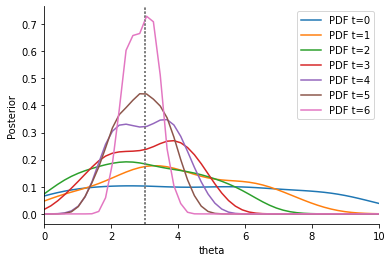

In [8]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(db_path, observation)
h_uni = abc.run(max_nr_populations=7)

plot_history(h_uni)

Next, we consider again a Euclidean distance with adaptive weights.

ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=4, start_time=2021-07-31 00:18:11>
ABC INFO: Calibration sample t = -1.
ABC.Distance DEBUG: Scale weights[0] = {'s1': 4.4129e-01, 's2': 1.4416e-01, 's3': 1.3201e+01}
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 3.94712144e+01.
ABC INFO: Accepted: 100 / 227 = 4.4053e-01, ESS: 1.0000e+02.
ABC.Distance DEBUG: Scale weights[1] = {'s1': 3.7888e-01, 's2': 1.4278e-01, 's3': 1.5343e+01}
ABC INFO: t: 1, eps: 4.49076898e+01.
ABC INFO: Accepted: 100 / 450 = 2.2222e-01, ESS: 9.6518e+01.
ABC.Distance DEBUG: Scale weights[2] = {'s1': 4.3149e-01, 's2': 1.6258e-01, 's3': 1.3212e+01}
ABC INFO: t: 2, eps: 3.80560279e+01.
ABC INFO: Accepted: 100 / 995 = 1.0050e-01, ESS: 9.8947e+01.
ABC.Distance DEBUG: Scale weights[3] = {'s1': 4.2335e-01, 's2': 1.3983e-01, 's3': 1.4754e+01}
ABC INFO: t: 3, eps: 4.19690989e+01.
ABC INFO: Acce

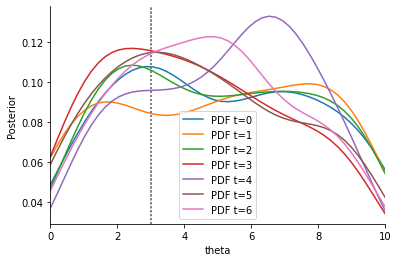

In [9]:
distance_adaptive = pyabc.AdaptivePNormDistance(
    p=2,
    scale_function=pyabc.distance.mad,
)

abc = pyabc.ABCSMC(
    model,
    prior,
    distance_adaptive,
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),
)
abc.new(db_path, observation)
h_ada = abc.run(max_nr_populations=7)

plot_history(h_ada)

These results are as expected: The adaptive weights make the situation much worse, as the impact of the low-variance outlier statistic is increased. Our solution is to firstly use outlier-robust metrics such as a Manhattan distance (p=1), instead of the Euclidean distance used above, which emphasizes large errors.

ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=5, start_time=2021-07-31 00:18:31>
ABC INFO: Calibration sample t = -1.
ABC.Distance DEBUG: Scale weights[0] = {'s1': 4.0712e-01, 's2': 1.2269e-01, 's3': 1.3265e+01}
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 4.21535023e+01.
ABC INFO: Accepted: 100 / 189 = 5.2910e-01, ESS: 1.0000e+02.
ABC.Distance DEBUG: Scale weights[1] = {'s1': 4.2649e-01, 's2': 1.6058e-01, 's3': 1.2175e+01}
ABC INFO: t: 1, eps: 3.78006682e+01.
ABC INFO: Accepted: 100 / 357 = 2.8011e-01, ESS: 9.0475e+01.
ABC.Distance DEBUG: Scale weights[2] = {'s1': 5.3054e-01, 's2': 1.4700e-01, 's3': 1.3336e+01}
ABC INFO: t: 2, eps: 4.05956252e+01.
ABC INFO: Accepted: 100 / 432 = 2.3148e-01, ESS: 7.9099e+01.
ABC.Distance DEBUG: Scale weights[3] = {'s1': 7.3950e-01, 's2': 1.5320e-01, 's3': 1.4070e+01}
ABC INFO: t: 3, eps: 4.22678419e+01.
ABC INFO: Acce

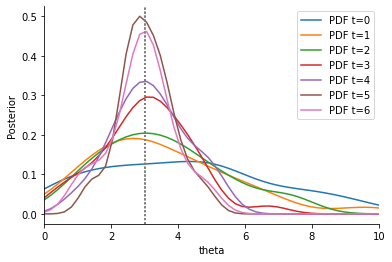

In [10]:
scale_log_file_l1 = tempfile.mkstemp(suffix=".json")[1]

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,  # new, previously p=2
    scale_function=pyabc.distance.mad,
    scale_log_file=scale_log_file_l1,
)

abc = pyabc.ABCSMC(
    model,
    prior,
    distance_adaptive,
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),
)
abc.new(db_path, observation)
h_l1 = abc.run(max_nr_populations=7)

plot_history(h_l1)

This visibly improves the estimates again. However, the outlier statistic still seems to have a considerable impact, as the estimates are considerably worse than without s3. This can be tackled by actively identifying and down-weighting outlier data points, by using a different weighting scheme than MAD. We propose to use the PCMAD (Perhaps-Combined MAD), which either uses MAD, or, if the fraction of severe outliers detected is not too high (precisely not more than 1/3, see the publication and the API for details), uses MAD + MADO, where MADO is the median absolute deviation to the observed value.

ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=6, start_time=2021-07-31 00:18:39>
ABC INFO: Calibration sample t = -1.
ABC.Distance INFO: Features ['s3'] (ixs=[2]) have a high bias.
ABC.Distance DEBUG: Scale weights[0] = {'s1': 2.1253e-01, 's2': 6.0377e-02, 's3': 3.2332e-01}
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 2.00529027e+00.
ABC INFO: Accepted: 100 / 197 = 5.0761e-01, ESS: 1.0000e+02.
ABC.Distance INFO: Features ['s3'] (ixs=[2]) have a high bias.
ABC.Distance DEBUG: Scale weights[1] = {'s1': 2.1935e-01, 's2': 7.6574e-02, 's3': 3.2551e-01}
ABC INFO: t: 1, eps: 1.66449293e+00.
ABC INFO: Accepted: 100 / 269 = 3.7175e-01, ESS: 9.4967e+01.
ABC.Distance INFO: Features ['s3'] (ixs=[2]) have a high bias.
ABC.Distance DEBUG: Scale weights[2] = {'s1': 3.9610e-01, 's2': 7.6976e-02, 's3': 3.2499e-01}
ABC INFO: t: 2, eps: 1.68204559e+00.
ABC INFO: Accepte

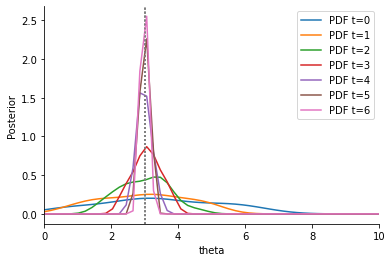

In [11]:
scale_log_file_pcmad = tempfile.mkstemp(suffix=".json")[1]

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,
    scale_function=pyabc.distance.pcmad,  # new, previously mad
    scale_log_file=scale_log_file_pcmad,
)

abc = pyabc.ABCSMC(
    model,
    prior,
    distance_adaptive,
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),
)
abc.new(db_path, observation)
h_pcmad = abc.run(max_nr_populations=7)

plot_history(h_pcmad)

This visibly improves the obtained estimates further. This is due to the respective weights assigned: PCMAD correctly identifies the outlier and assigns a low weight.

<AxesSubplot:xlabel='Summary statistic', ylabel='Weight'>

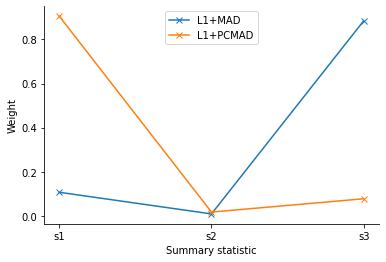

In [12]:
pyabc.visualization.plot_distance_weights(
    [scale_log_file_l1, scale_log_file_pcmad],
    labels=["L1+MAD", "L1+PCMAD"],
)

This result is further obtained with less samples.

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

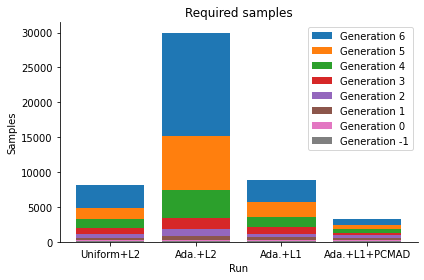

In [13]:
pyabc.visualization.plot_sample_numbers(
    [h_uni, h_ada, h_l1, h_pcmad],
    ["Uniform+L2", "Ada.+L2", "Ada.+L1", "Ada.+L1+PCMAD"],
)

## Conclusion

In general, we recommend the consistent use of an L1 norm over L2, unless squared residuals are needed. This makes the analysis robust to outliers, and further has also shown advantageous on high-dimensional data, where highly deviant points are likely to exist. Further, PCMAD has proven stable and advantageous on multiple test problems, on both outlier-free and outlier-corrupted data. On highly flexible models, it may be unable to reliably detect errors, such that it resorts to MAD. In the implementation in pyABC, PCMAD informs about potential outliers early-on via the logging modules.

## Problems

The scale-normalized outlier-robust distance functions presented above clearly still have several shortcomings. In particular, they do not account for how "informative" data points are. This can e.g. be problematic if the data contain large quantities of uninformative data points with background noise that would be enlarged by the here-employed scale normalization. Another problem occurs when many data points are informative of one parameter, but only few of another, in which case one could argue that the impact of the many and the few should be balanced better in order to extract information on both parameters. To some degree, these problems can be tackled by additional `fixed_weights`, which pyABC allows to define manually, but this may be cumbersome, and it may be preferable to a-priori define a set of similarly informative summary statistics, e.g. using the [regression-based summary statistics](https://rss.onlinelibrary.wiley.com/doi/pdfdirect/10.1111/j.1467-9868.2011.01010.x) by Fearnhead and Prangle, which are also implemented in pyABC.

For an overview of approaches accounting for both scale and informativeness of data, see the notebook on "Informative distances and summary statistics".